In [28]:
%matplotlib widget
import pickle
import pandas as pd
import numpy as np
from capsubot_env.capsubot import Capsubot
from capsubot_env.capsubot_env_to_point import CapsubotEnvToPoint
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List

In [29]:
from brute_mpc import *
def get_classic_optimal(timestamps):
    T=0.0441
    tau= 1 - 0.785
    force_func = lambda t: classic_force_model(t, T, tau)
    dt = MIN_DT
    duration = timestamps[-1]
    agent = Capsubot(dt=dt, frame_skip=1, model=1)
    agent.reset()

    classic_data = {"states" : [], "actions" : [], "timestamps" : []}
    while agent._total_time <= duration:
        action = force_func(agent.get_total_time)
        agent.step(action=action)
        classic_data["states"].append(agent.get_state)
        classic_data["actions"].append(action)
        classic_data["timestamps"].append(agent.get_total_time)

    return classic_data

dCoordinate 0.002484244056451479


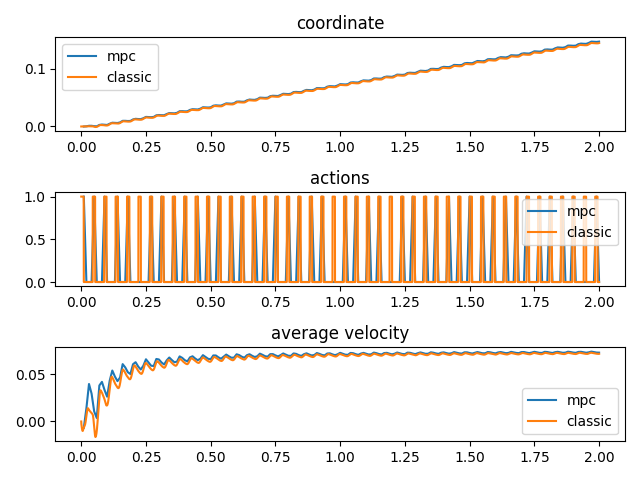

In [30]:
data = {}
with open('data.pkl', 'rb') as fp:
    data = pickle.load(fp)
fig, axs = plt.subplots(3)
axs[0].plot(data["timestamps"], [x[0] for x in data["states"]], label="mpc")
axs[1].plot(data["timestamps"], data["actions"], label="mpc")
axs[2].plot(data["timestamps"], [x[0]/t for x, t in zip(data["states"], data["timestamps"])], label="mpc")
classic_data = get_classic_optimal(data["timestamps"])
axs[0].plot(classic_data["timestamps"], [x[0] for x in classic_data["states"]], label="classic")
axs[1].plot(classic_data["timestamps"], classic_data["actions"], label="classic")
axs[2].plot(classic_data["timestamps"], [x[0]/t for x, t in zip(classic_data["states"], classic_data["timestamps"])], label="classic")

for ax in axs:
    ax.legend()

axs[0].set_title(f'coordinate')
axs[1].set_title(f'actions')
axs[2].set_title(f'average velocity')
fig.tight_layout()

print(f'dCoordinate {data["states"][-1][0] - classic_data["states"][-1][0]}')

Text(0, 0.5, 'средняя скорость, м/с')

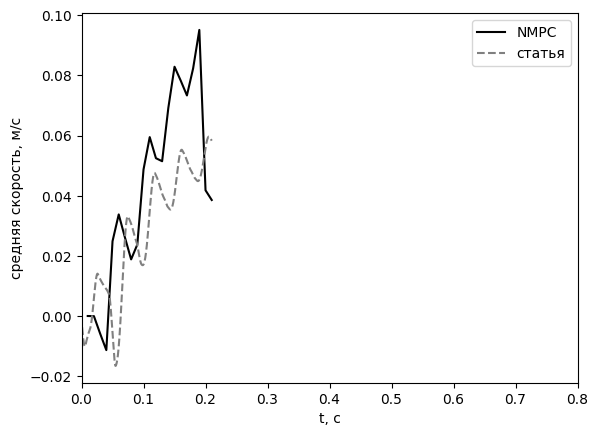

In [64]:
mpc_original = [x[0]/t for x, t in zip(data["states"], data["timestamps"])]
# plt.plot(data["timestamps"], mpc_original, label="mpc")

class_vx = [x[0]/t for x, t in zip(classic_data["states"], classic_data["timestamps"])]


mpc_modified = mpc_original.copy()
for idx in range(len(mpc_original)):
    if (data["timestamps"][idx] < 0.03):
        continue
    for jdx in range(len(classic_data["timestamps"])):
        if classic_data["timestamps"][jdx] < data["timestamps"][idx] + 0.02:
            continue
        mpc_modified[idx] = mpc_original[idx] + class_vx[jdx]
        break
    
# mpc_modified = [mpc]


plt.plot(data["timestamps"], mpc_modified, label="NMPC", color="k")
plt.plot(classic_data["timestamps"], class_vx, label="статья", color="gray", linestyle="--")
plt.legend()
plt.xlim((0.0, 0.8))
plt.xlabel("t, с")
plt.ylabel("средняя скорость, м/с")

Text(0, 0.5, 'координата корпуса, м')

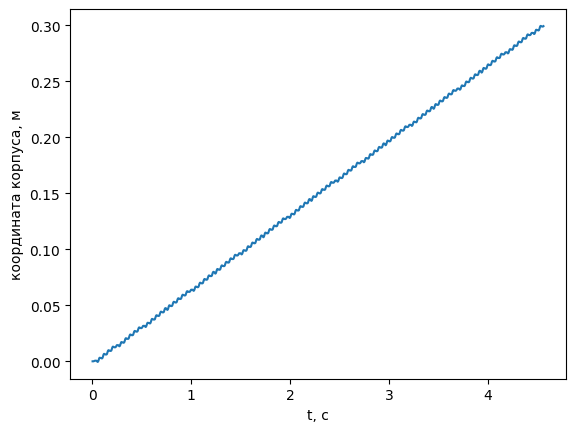

In [221]:
new_timestamps = [0, 5.0]
classic_data = get_classic_optimal(new_timestamps)

kdx = 0
while classic_data["states"][kdx][0] <= 0.3:
    kdx += 1
mean_v = [x[0] for x in classic_data["states"]]
plt.plot(classic_data["timestamps"][:kdx], mean_v[:kdx], label="classic")
classic_data["timestamps"][:kdx][-1]
plt.xlabel("t, с")
plt.ylabel("координата корпуса, м")